# AdjSim Tutorial

AdjSim is an agent-based modelling engine. It allows users to define simulation environments through which agents interact through ability casting and timestep iteration. It is tailored towards allowing agents to behave intelligently through the employment of Reinforcement Learning techniques such as Q-Learning. 

This tutorial will enumerate many of AdjSim's features through the construction of a simulation where a group of agents will play a game of tag. Lets dive in!

---

## Simulation: The Stuff Container

AdjSim simulations take place inside the fittingly named `Simulation` object.

Lets begin by importing our libararies.

In [1]:
import adjsim
import numpy as np # AdjSim also heavily relies on numpy. Its usage is recommended.
from matplotlib import pyplot

# Magic function to display matplotlib plots inline in the Jupyter Notebook. Not crucial for AdjSim.
%matplotlib inline 

We will make a trivial empty simulation to display its usage.

In [2]:
sim = adjsim.core.Simulation()

# Interactive simulation method.
sim.start() # Begin the simulation.
sim.step() # Take one step.
sim.step(10) # Take 10 steps.
sim.end() # end the simulation.

# Batch simulation method.
sim.simulate(100) # Start, Simulate for 100 timesteps, End. All in one go.

Simulating timestep 100/100 - population: 0

Its a little lonely in that simulation, lets add an agent.

In [3]:
sim.agents.add(adjsim.core.Agent())
sim.agents.add(adjsim.core.Agent())

sim.simulate(100)

Simulating timestep 100/100 - population: 2 

Things are happening, but its a little hard to see. Lets visualize our simulation space. Simulations and agents have a hierarchal class structure. `VisualSimulation` inherits from `Simulation`, and can be used to display a 2D simulation environment.

In [4]:
sim = adjsim.core.VisualSimulation()
sim.simulate(15)

Simulating timestep 15/15 - population: 0 

Similarly, an appropriate `VisualAgent` must be present in the simulation space if it is to be seen. The agent inheritance hierarchy is as follows:

1. `Agent`: The base agent class. Contains the attributes that are minimally needed in order for an agent to be simulated.
2. `SpatialAgent`: Adds the presence of the `pos` Attribute, allowing for a 2D position to be associated with an agent.
3. `VisualAgent`: Adds the attributes needed for visualization on top of those of `SpatialAgent`. This is the minimum class needed for an agent to appear inside a `VisualSimulation`.

In [5]:
sim.agents.add(adjsim.core.VisualAgent(pos=np.array([1,1])))
sim.simulate(15)

Simulating timestep 15/15 - population: 1 

Now we should see our agent (shown in the image below). 

<img src="https://raw.githubusercontent.com/SeverTopan/AdjSim/v2.1-dev/tutorial/images/1.PNG" alt="Single Agent" style="width: 200px;"/>

Next, lets make it do things.

---

## Agents: Making This Space Less Lonely

Agents are simulation artifacts that manipulate the simulation environment. In the adjsim model, within each timestep agents take turns acting out their environment manipulations. One iteration of an agent's environment manipulations is known as an agent's __step__.

There are two major aspects to an agent's __step__: 

1. A set of __actions__. An __action__ defines one distinct user-defined set of computations that the agent manipulates its environment with. It is simply a python function. The actions we will be defining in our simulation of the game of tag will be a _move_ and a _tag_ action.
2. A decision module. Decision modules are AdjSim objects that an agent uses to choose which actions to perform, and in what order.

We'll start by making an agent that can _move_, but that can't _tag_. The _move_ action will allow an agent to move in a random direction bounded by a square arena.

In [6]:
# Constants.
ARENA_BOUND = 100
MOVE_DIST = 20

# Actions must follos the following signiature. 
# The Simulation object will be passed in as the 'simulation' parameter.
# The agent calling the action will be passed as the 'source' parameter.
def move(simulation, source):
    movement = (np.random.rand(2) - 0.5) * MOVE_DIST
    source.pos = np.clip(source.pos + movement, -ARENA_BOUND, ARENA_BOUND)
    source.step_complete = True

The final line, `source.step_complete = True`, lets the decision module know that no further actions can be completed in the agent's __step__ after the current one. 

Now let's create an agent that uses this action. The agent we will be creating will have a `RandomRepeatedCastDecision`. This decision module will randomly select actions and invoke them until the `source.step_complete` attribute is true. This should result in one cast of the above-defined _move_ action.

In [7]:
class Mover(adjsim.core.VisualAgent):
    def __init__(self, x, y):
        super().__init__(pos=np.array([x, y]))
        
        # Set the decision module.
        self.decision = adjsim.decision.RandomSingleCastDecision()

        # Populate the agent's action list.
        self.actions["move"] = move

Let's take it out for a spin.

In [8]:
sim = adjsim.core.VisualSimulation()
sim.agents.add(Mover(0, 0))

sim.simulate(15)

Simulating timestep 15/15 - population: 1 

We observe an agent moving in random directions in each timestep. 

<img src="https://raw.githubusercontent.com/SeverTopan/AdjSim/v2.1-dev/tutorial/images/2.gif" alt="Single Agent" style="width: 400px;"/>


Nice! Lets give it some friends.

In [9]:
class MoverSimulation(adjsim.core.VisualSimulation):
    def __init__(self):
        super().__init__()

        for i in range(5):
            for j in range(5):
                self.agents.add(Mover(20*i, 20*j))
                
sim = MoverSimulation()
sim.simulate(15)

Simulating timestep 15/15 - population: 25 

We should now see a group of 25 agents moving in a similar fashion to our first one. 

<img src="https://raw.githubusercontent.com/SeverTopan/AdjSim/v2.1-dev/tutorial/images/3.gif" alt="Single Agent" style="width: 400px;"/>

The basics are now covered. Lets put together our simulation of a game of tag.

---

## Basic AdjSim Usage: Putting It All Together

The following will describe our simulation of a game of tag.

In [10]:
# Reiterate imports.
import adjsim
import numpy as np
import sys

# Constants.
ARENA_BOUND = 100
TAG_DIST_SQUARE = 100
MOVE_DIST = 20

def move(simulation, source):
    movement = (np.random.rand(2) - 0.5) * MOVE_DIST
    source.pos = np.clip(source.pos + movement, -ARENA_BOUND, ARENA_BOUND)
    source.step_complete = True

def tag(simulation, source):  
    if not source.is_it:
        return
    
    if source.cooldown > 0:
        source.cooldown -= 1
        source.step_complete 
        return

    # Find nearest neighbour.
    closest_distance = sys.float_info.max
    nearest_neighbour = None
    for agent in simulation.agents:
        if agent.id == source.id:
            continue

        distance = adjsim.utility.distance_square(agent, source)
        if distance < closest_distance:
            nearest_neighbour = agent
            closest_distance = distance

    if closest_distance > TAG_DIST_SQUARE:
        return

    assert nearest_neighbour

    # Perform Tag.
    nearest_neighbour.is_it = True
    nearest_neighbour.color = adjsim.color.RED_DARK # This will change the agent's visual color.
    nearest_neighbour.order = 1 # Order describes what order the agents will take their steps in the simulation loop.
    nearest_neighbour.cooldown = 5
    source.is_it = False
    source.order = 0 # Order describes what order the agents will take their steps in the simulation loop.
    source.color = adjsim.color.BLUE_DARK # This will change the agent's visual color.

class Tagger(adjsim.core.VisualAgent):

    def __init__(self, x, y, is_it):
        super().__init__()

        self.is_it = is_it
        self.cooldown = 5 if is_it else 0
        self.color = adjsim.color.RED_DARK if is_it else adjsim.color.BLUE_DARK
        self.pos = np.array([x, y])
        self.decision = adjsim.decision.RandomSingleCastDecision()

        self.actions["move"] = move
        self.actions["tag"] = tag

        if is_it:
            self.order = 1 # Order describes what order the agents will take their steps in the simulation loop.


class TaggerSimulation(adjsim.core.VisualSimulation):

    def __init__(self):
        super().__init__()

        for i in range(5):
            for j in range(5):
                self.agents.add(Tagger(20*i, 20*j, False))

        self.agents.add(Tagger(10, 10, True))
        
sim = TaggerSimulation()
sim.simulate(15)

Simulating timestep 15/15 - population: 26 

And that's it! We should observe a game of tag being played where the 'it' agent is red. It will tag the agents around it when it has the chance. 

<img src="https://raw.githubusercontent.com/SeverTopan/AdjSim/v2.1-dev/tutorial/images/4.gif" alt="Single Agent" style="width: 400px;"/>

---

## Trackers: Introspection Into The Simulation

We can procedurally extract information from the simulation using a `Tracker`. Trackers are functors that log information at runtime. 

### Built-In Trackers

We'll start by taking a look at some built-in AdjSim Trackers. They can be found within the `adjsim.analysis` module. Let's keep track of the global agent count.

Simulating timestep 15/15 - population: 26 

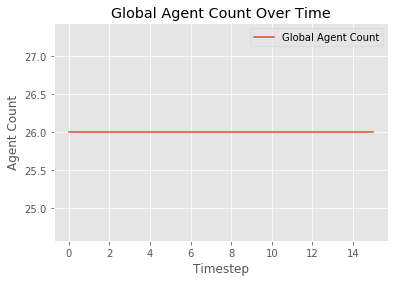

In [11]:
sim = TaggerSimulation()
sim.trackers["agent_count"] = adjsim.analysis.AgentCountTracker()
sim.simulate(15)
sim.trackers["agent_count"].plot()

Not incredibly insightful, eh? (as expected, since our agent population is not changing in this particular simulation). Lets see if we can do better.

### Custom Trackers

Let's make our own tracker that tracks when tags take place. A Tracker must implement a `__call__(self, simulation)` method, and store relevant data that it would like to store within its `self.data` attribute. It is also recommended but optional to implement a `plot` method.

In [12]:
class TagCountTracker(adjsim.analysis.Tracker):
    def __init__(self):
        super().__init__()
        self.data = []
        self.tag_count = 0
        self.last_it_agent = None

    def __call__(self, simulation):
        for agent in simulation.agents:
            if agent.is_it:
                # Trackers will be called once before the first simulation loop, so we ignore the first
                # changing of agents since it resembles the agent that is starting in the 'it' state.
                if agent != self.last_it_agent: 
                    self.last_it_agent = agent
                    if  simulation.time > 0:
                        self.tag_count += 1
                    
        # Append the data.
        self.data.append(self.tag_count)

    def plot(self):
        pyplot.style.use('ggplot')

        line, = pyplot.plot(self.data, label="Global Tag Count")
        line.set_antialiased(True)

        pyplot.xlabel('Timestep')
        pyplot.ylabel('Tag Count')
        pyplot.title('Global Tag Count Over Time')
        pyplot.legend()

        pyplot.show()

Now lets test it out.

Simulating timestep 50/50 - population: 26 

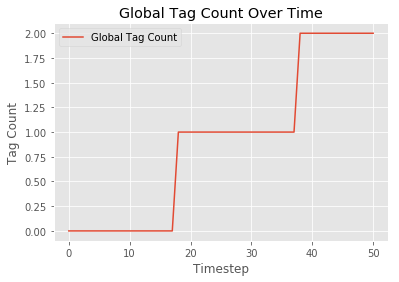

In [26]:
sim = TaggerSimulation()
sim.trackers["tag_count"] = TagCountTracker()
sim.simulate(50)
sim.trackers["tag_count"].plot()

That covers the basics. Essentially any data structure can be stored in a tracker and any user code can be run. It is meant to be an architectural handle for obtaining data about the simulation _in between_ timesteps.

## Decisions: Filling the Noggin'

The agents so far act randomly. Let's fix that.

### Using Reinforcement Learning-Enabled Decision Models

In this part of the tutorial we will be exploring AdjSim's Functional Decision model. This is the architecture that is used by the decision modules that employ Reinforcement Learning within AdjSim. 

The model asserts that there are two additional pieces of information that need to be given to an agent in order for it to be able to make intelligent decisions:

1. A __Loss Function__: This function essentially gives an agent a score as to how well its doing. Functional decision modules attempy to __minimize__ their associated loss function. For example, taggers try to minimize the amount of time they spend tagged, or bacteria try to maximize their calories.
2. A __Perception Function__: A function that processes the simulation from the perspective of an agent, and returns an object that is then used as input to the decision module for the purposes of invoking intelligent actions. For example, a given `Tagger` should be aware of where the `Tagger` that is 'it' is located relative to itsef. The perception acts as a filter between the omniscient data present within a simulation and the data that an agent may use to make its decisions. An invocation of a __Perception__ at a particular timestep is known as a __Observation__.



Overall, the processing workflow in an agent __step__ is the following.

$$
\text{Simulation} \rightarrow \text{Perception Function} \rightarrow \text{(Observation)} \rightarrow \text{Decision Module}
$$

Then the decision module is responsible for selecting and invoking the appropriate actions.

$$
\text{Decision Module} \rightarrow \text{Actions} \rightarrow \text{(Environment Manipulations)}
$$

Finally, the decision module evaluates the efficacy of its actions through the __Loss Function__ evaluation. It uses these results to train itself to make better future decisions.

$$
\text{Decision Module} \rightarrow \text{Loss Function} \rightarrow \text{(Efficacy Evaluation Score)} \rightarrow \text{Decision Module}
$$



We're going to start by making the agents of our simulation choose the right action between moving and tagging. Note that the direction of movement is still random. Parameterized functions will be covered in the next section. For our __Loss Function__, we will be using the `is_it` attribute to discourage being tagged. 

In [14]:
# Call signiature must be the following, same as an action.
def tagger_loss(simulation, source):
    return 10 if source.is_it else 0

Our __Perception Function__ will return two parameters:

1. Whether or not the agent is 'it'
2. The relative location of the nearest agent if the agent is 'it', otherwise the relative location of the 'it' agent. This will be done in polar coordinates.

Since we will be using Q-Learning for this simulation, each __Observation__ will define a state of the agent. Since relative location involves continuous values (floats), we find ourselves with an infinite number of possible agent states. In order to make the algorithm palpable we will discretize the values obtained that would otherwise be returned from the perception function. This need to discretize states is a idiosyncracy of the Q-Learning algorithm, and may not be needed when other decision modules are used.

In [15]:
import math

def find_it_tagger(simulation, source):
    for agent in simulation.agents:
        if agent.is_it:
            return agent
        
    # Raise an error if not found, this should never happen.
    raise Exception("'it' agent not found.")

def find_closest_non_it_tagger(simulation, source):
    closest_distance = sys.float_info.max
    nearest_neighbour = None
    for agent in simulation.agents:
        if agent.id == source.id:
            continue

        distance = adjsim.utility.distance_square(agent, source)
        if distance < closest_distance:
            nearest_neighbour = agent
            closest_distance = distance

    return nearest_neighbour

def tagger_perception(simulation, source):
    agent = None
    
    # Find appropriate agent and distance.
    if source.is_it:
        agent = find_closest_non_it_tagger(simulation, source)
    else:
        agent = find_it_tagger(simulation, source)

    # Obtain theta value.
    delta = agent.pos - source.pos
    theta = math.atan(delta[1]/delta[0]) if delta[0] != 0 else np.sign(delta[1])*math.pi/2
    distance = np.sum(delta**2)**0.5

    # Discretize observation to reduce number of possible states.
    rounded_theta = round(theta/(math.pi/20))*(math.pi/20)
    rounded_distance = round(distance/10)*10

    return (rounded_theta, rounded_distance, source.is_it)

Now, let's put together our simulation. It is important to note that we will be sharing our decision module object across all our Taggers in the same way that actions are shared. This will allow training to occur collectively, and allow all agents to learn from each other's enterprises.

In [16]:
class SomewhatCleverTagger(adjsim.core.VisualAgent):

    def __init__(self, x, y, is_it, _decision):
        super().__init__()

        self.is_it = is_it
        self.cooldown = 5 if is_it else 0
        self.color = adjsim.color.RED_DARK if is_it else adjsim.color.BLUE_DARK
        self.pos = np.array([x, y])
        self.decision = _decision

        self.actions["move"] = move
        self.actions["tag"] = tag

        if is_it:
            self.order = 1


class SomewhatCleverTaggerSimulation(adjsim.core.VisualSimulation):

    def __init__(self):
        super().__init__()
        
        # Let's create the collective decision module. We will load and save our progress to the same file.
        io_file_name = "somewhat_clever_tagger.qlearning.pkl"
        self.tagger_decision = adjsim.decision.QLearningDecision(perception=tagger_perception, loss=tagger_loss, 
            simulation=self, input_file_name=io_file_name, output_file_name=io_file_name)

        for i in range(5):
            for j in range(5):
                self.agents.add(SomewhatCleverTagger(20*i, 20*j, False, self.tagger_decision))

        self.agents.add(SomewhatCleverTagger(10, 10, True, self.tagger_decision))
        
sim = SomewhatCleverTaggerSimulation()
sim.simulate(15)

Q Learning training data found, loading from somewhat_clever_tagger.qlearning.pkl...done
Simulating timestep 15/15 - population: 26 Processing Q-Learning data...done
Saving Q-Learning data...done


So now we are prepared to run the simulation a series of times, and after training the bacteria will be able to choose _which_ of _move_ or _tag_ they should choose. We will go into more detail regarding the training/testing cycle in the next example, where the results will be more flashy.

---

### Parameterizing Actions Using Decision-Mutable Values

We not only want our taggers to know which action to perform (between _move_ and _tag_), but also what direction to move when they perform their _move_ action. We accomplish this using Decision-Mutable Values. These are variable that a decision module will try to optimize for when performing its training cycle. These values are never explicitly set by the user. The decision module will set its value during runtime, before calling each action. These values are effectively read-only for the consumer of the API. 

Let's take a look. We will begin by re-writing our _move_ function.

In [17]:
def clever_move(simulation, source):
    # We need to convert polar movement coordinates to cartesian.
    move_rho = source.move_rho.value
    move_theta = source.move_theta.value

    dx = math.cos(move_theta) * move_rho
    dy = math.sin(move_theta) * move_rho

    movement = np.array([dx, dy])

    source.pos = np.clip(source.pos + movement, -ARENA_BOUND, ARENA_BOUND)
    source.step_complete = True
        
        
class ProperlyCleverTagger(adjsim.core.VisualAgent):
    def __init__(self, x, y, is_it, _decision):
        super().__init__()

        self.is_it = is_it
        self.cooldown = 5 if is_it else 0
        self.color = adjsim.color.RED_DARK if is_it else adjsim.color.BLUE_DARK
        self.pos = np.array([x, y])
        self.decision = _decision
        
        # This is where the new magic lies. 
        self.move_rho = adjsim.decision.DecisionMutableFloat(0, MOVE_DIST)
        self.move_theta = adjsim.decision.DecisionMutableFloat(0, 360)

        self.actions["move"] = clever_move
        self.actions["tag"] = tag

        if is_it:
            self.order = 1

Now we have properly clever taggers. Let's train them. We will make a train simulation and a test simulation, and run the training for a number of epochs. Let's see how they do!

In [18]:
class ProperlyCleverTaggerTrainSimulation(adjsim.core.Simulation): # Note that the simulation is not visual for training.

    def __init__(self):
        super().__init__()
        
        io_file_name = "properly_clever_tagger.qlearning.pkl"
        self.tagger_decision = adjsim.decision.QLearningDecision(perception=tagger_perception, loss=tagger_loss, 
            simulation=self, input_file_name=io_file_name, output_file_name=io_file_name)

        for i in range(5):
            for j in range(5):
                self.agents.add(ProperlyCleverTagger(20*i, 20*j, False, self.tagger_decision))

        self.agents.add(ProperlyCleverTagger(10, 10, True, self.tagger_decision))
        
class ProperlyCleverTaggerTestSimulation(adjsim.core.VisualSimulation): # Note that the simulation is not visual for training.

    def __init__(self):
        super().__init__()
        
        io_file_name = "properly_clever_tagger.qlearning.pkl"
        self.tagger_decision = adjsim.decision.QLearningDecision(perception=tagger_perception, loss=tagger_loss, 
            simulation=self, input_file_name=io_file_name, output_file_name=io_file_name, nonconformity_probability=0)

        for i in range(5):
            for j in range(5):
                self.agents.add(ProperlyCleverTagger(20*i, 20*j, False, self.tagger_decision))

        self.agents.add(ProperlyCleverTagger(10, 10, True, self.tagger_decision))
        
# Training cycle.
EPOCHS = 10 
for i in range(EPOCHS):
    print("Epoch:", i)
    sim = ProperlyCleverTaggerTrainSimulation()
    sim.simulate(700)

Epoch: 0
Q Learning training data found, loading from properly_clever_tagger.qlearning.pkl...done
Simulating timestep 700/700 - population: 26 Processing Q-Learning data...done
Saving Q-Learning data...done
Epoch: 1
Q Learning training data found, loading from properly_clever_tagger.qlearning.pkl...done
Simulating timestep 700/700 - population: 26 Processing Q-Learning data...done
Saving Q-Learning data...done
Epoch: 2
Q Learning training data found, loading from properly_clever_tagger.qlearning.pkl...done
Simulating timestep 700/700 - population: 26 Processing Q-Learning data...done
Saving Q-Learning data...done
Epoch: 3
Q Learning training data found, loading from properly_clever_tagger.qlearning.pkl...done
Simulating timestep 700/700 - population: 26 Processing Q-Learning data...done
Saving Q-Learning data...done
Epoch: 4
Q Learning training data found, loading from properly_clever_tagger.qlearning.pkl...done
Simulating timestep 700/700 - population: 26 Processing Q-Learning data...

After completing our training cycles, we expect to have intelligently acting agents! Lets take a look with our testing simulation. We will also plot a graph of agent loss over time (for anecdotal introspection into the simulation). It will show how each individual agent percieves how well its doing (the higher the value, the worse the performance). We will observe graph spikes when an agent is tagged. 

Q Learning training data found, loading from properly_clever_tagger.qlearning.pkl...done
Simulating timestep 500/500 - population: 26 Processing Q-Learning data...

C:\Users\Sev\Anaconda3\envs\adjsim\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


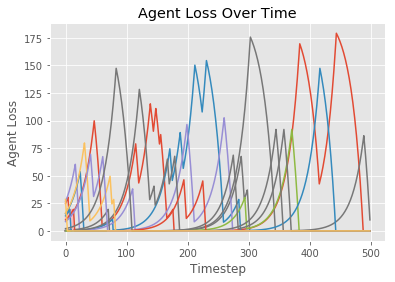

done
Saving Q-Learning data...done


In [19]:
# Testing Cycle.
sim = ProperlyCleverTaggerTestSimulation()
sim.simulate(500)


Our agents now make intelligent decisions.

<img src="https://raw.githubusercontent.com/SeverTopan/AdjSim/v2.1-dev/tutorial/images/5.gif" alt="Single Agent" style="width: 400px;"/>

A short commentary about the observed behaviour: Notice how the "non-it" agents don't unconditionally flee from the "it" one, instead several of the closer agents seem to taunt it back and forth. Since the "it" agent only percieves the closest non-it agent, the "non-it" agents have acutally learned to exlpoit the vulnerability of the "it" agent's perception limitations, forcing it to switch back and forth between its targets. Pretty cool!

---

## Indices: Finding Friends Efficiently

Indices provide data structures that allow for lower complexity look-up of agents. There is currently one index defined in Canonical AdjSim. It is the `GridIndex`, and it allows us to perform neighbour searches upon grid-based simulations with ease. We won't go through a full example here, if that is desired please see the [Conway's Game Of Life example](https://github.com/SeverTopan/AdjSim/blob/master/examples/game_of_life/simulation.py). Here is a brief overview.

### GridIndex: Being Discrete

Before starting the simulation an index needs to be initialized. The parameter passed in is the size of one side of the grid (the grid is always square). The grid is infinitely spanning, as it is implemented using hash tables, so no global bounds need be provided. Multiple agents can inhabit one cell.

In [20]:
grid_sim = adjsim.core.Simulation()
grid_sim.indices.grid.initialize(5) # We now have a 5x5 infinitely spanning grid index.

# Add some agents. Their positions should lie in grid cells.
# Otherwise the positions are rounded to the nearest cell.
grid_sim.agents.add(adjsim.core.SpatialAgent(pos=np.array([5, 5])))
grid_sim.agents.add(adjsim.core.SpatialAgent(pos=np.array([5, 5])))
grid_sim.agents.add(adjsim.core.SpatialAgent(pos=np.array([0, 0])))

Now lets take a look at the lookup functions that the grid provides:

#### `get_inhabitants`

O(1) lookup of agents inhabiting a single cell, or a list of cell coordinates.

In [21]:
grid_sim.indices.grid.get_inhabitants(np.array([5, 5]))

#### `get_neighbour_coordinates`

returns the coordinates of the 8 cells neighbouring any particular cell.

In [22]:
grid_sim.indices.grid.get_neighbour_coordinates(np.array([-5, 0]))

[array([ 0.,  0.]),
 array([ 0.,  5.]),
 array([-5.,  5.]),
 array([-10.,   5.]),
 array([-10.,   0.]),
 array([-10.,  -5.]),
 array([-5., -5.]),
 array([ 0., -5.])]

#### `get_neighbours`

O(1) lookup of agents inhabiting the 8 cells surrounding a target coordinate.

In [23]:
grid_sim.indices.grid.get_neighbours(np.array([5, 0]))

More indices to come, stay posted :).

---

## Callbacks: Systematic User Code Invocation

Callbacks allow user code to be called at specific points during the simulation. Callbacks provide the following interface:

1. `register`: Register a function with a given callback.
2. `unregister`: Unregister a function from a callback.
3. `is_registered`: Returns whether or not a given function is registered.

There are currently 6 callbacks in an AdjSim simulation. The first are agent callbacks, and pass in a single parameter to the callback function that is registered. This parameter is an Agent.
* `agent_added`: Fires when an Agent is added to the agent set.
* `agent_removed`: Fires when an Agent is removed from the agent set.
* `agent_moved`: Fires when a SpatialAgent's pos attribute is set.

The next set of callbacks also pass in a single parameter to their respective functions, this time a Simulation object.
* `simulation_step_started`: Fires when a Simulation step is started.
* `simulation_step_complete`: Fires when a Simulation step is ended.
* `simulation_started`: Fires when the Simulation starts.
* `simulation_complete`: Fires when the Simulation ends.


We'll demonstrate by creating a function that counts the number of agent movements.

In [24]:
def move_counter(agent):
    move_counter.count += 1
move_counter.count = 0

def trivial_move(simulation, source):
    source.pos = source.pos + np.array([1, 1])
    
class TrivialMover(adjsim.core.SpatialAgent):
    def __init__(self):
        super().__init__()
        self.actions["move"] = trivial_move
        self.decision = adjsim.decision.RandomSingleCastDecision()
        
callback_sim = adjsim.core.Simulation()
callback_sim.callbacks.agent_moved.register(move_counter)

callback_sim.agents.add(TrivialMover())
callback_sim.simulate(5)

move_counter.count

Simulating timestep 5/5 - population: 1 

5